# Семинар 14

# Метод Ньютона: дорого и быстро

## На прошлом семинаре...

1. Методы спуска
2. Направление убывания
3. Градиентный метод
4. Правила выбора шага
5. Теоремы сходимости
6. Эксперименты

## Недостатки градиентного спуска

- Линейная скорость сходимости
- Зависимость от числа обусловленности гессиана

Можно ли их одновременно преодолеть?

## Идея метода Ньютона
Рассмотрим задачу
$$
\min\limits_{x\ \in \mathbb{R}^n} f(x).
$$

- Градиентный спуск $\equiv$ **линейная** аппроксимация $f$
- Метод Ньютона $\equiv$ **квадратичная** аппроксимация $f$:
$$
f(x + h) \approx f(x) + \langle f'(x), h \rangle + \frac{1}{2}h^{\top}f''(x)h \to \min_{h}
$$
Из необходимого условия минимума:
$$
f'(x) + f''(x) h = 0, \qquad h^* = -(f''(x))^{-1} f'(x)
$$


### Является ли найденное направление направлением убывания?

Проверим знак скалярного произведения $\langle f'(x), h^* \rangle$.
$$
\langle f'(x), h^* \rangle = -(f')^{\top}(x) (f''(x))^{-1} f'(x) < 0 \Leftarrow f''(x) \succ 0
$$

**Вопрос:** а что если при некотором $k^*$ гессиан станет неопределён?



## Метод Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданному правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

## Теорема сходимости (Ю. Е. Нестеров Введение в выпуклую оптимизацию, $\S$ 1.2)

**Теорема.** Пусть функция $f(x)$
- дважды дифференцируема и её гессиан удовлетворяет условию Липшица с константой $M$
- существует точка локального минимума с положительно определённым гессианом
$$
f''(x^*) \succeq l\mathbf{I}, \; l > 0
$$
- начальная точка $x_0$ достаточно близка к точки минимума, в частности
$$
\|x_0 - x^*\|_2 \leq \frac{2l}{3M}
$$

Тогда метод Ньютона сходится **квадратично**:
$$
\|x_{k+1} - x^* \|_2 \leq \dfrac{M\|x_k - x^*\|^2_2}{2 (l - M\|x_k - x^*\|_2)}
$$

### Пример

Применим метод Ньютона для поиска корня следующей функции

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

и определим область сходимости.

## Аффинная инвариантность

Рассмотрим функцию $f(x)$ и невырожденное преобразование с матрицей $A$. 

Выясним, как изменится шаг метода Ньютона после преобразования $A$.

Пусть $x = Ay$ и $g(y) = f(Ay)$. Тогда
$$
g(y + u) \approx g(y) + \langle g'(y), u \rangle + \frac{1}{2} u^{\top} g''(y) u \to \min_{u}
$$
и
$$
u^* = -(g''(y))^{-1} g'(y) \qquad y_{k+1} = y_k - (g''(y_k))^{-1} g'(y_k)
$$
или

\begin{equation}
\begin{split}
y_{k+1} & = y_k - (A^{\top}f''(Ay_k)A)^{-1} A^{\top}f'(Ay_k)\\
& = y_k - A^{-1}(f''(Ay_k))^{-1}f'(Ay_k)
\end{split}
\end{equation}

Таким образом,

$$
Ay_{k+1} = Ay_k - (f''(Ay_k))^{-1}f'(Ay_k) \quad x_{k+1} = x_k - (f''(x_k))^{-1}f'(x_k)
$$

Следовательно, направление метода Ньютона преобразуется при 

линейном преобразовани так же, как и координаты!

## Вычислительная сложность и эксперименты

Узкие места метода Ньютона:

- формирование и хранение гессиана
- решение систем линейных уравнений
$$
f''(x_k)h = -f'(x_k)
$$

### Сравнение с градиентным спуском

Вспомним задачу нахождения аналитического центра системы неравенств $Ax \leq 1$ при условии $|x_i| \leq 1$
$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

$$
f'(x) - ? \quad f''(x) - ?
$$ 

In [1]:
import numpy as np
import sys
sys.path.append("..")
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 5000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

#### Точное решение с помощью CVXPy

In [2]:
import cvxpy as cvx
x = cvx.Variable(n, 1)

obj = cvx.Minimize(cvx.sum_entries(-cvx.log(1 - A.T * x)) - 
                   cvx.sum_entries(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
x = x.value
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1025200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 15200, constraints m = 30600
Cones:	soc vars: 15000, soc blks: 5000
	exp vars: 15600, dual exp vars: 0
Setup time: 5.45e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf      -inf       inf  8.83e-02 
   100| 2.64e+01  7.13e+00  6.81e-03 -5.93e+04 -5.85e+04  7.19e-13  3.89e+00 
   200| 6.79e+00  8.11e-01  5.47e-03 -4.46e+03 -4.41e+03  1.41e-12  8.48e+00 
   3

#### Вспомогательные функции

In [2]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

#### Реализация метода Ньютона

In [3]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

#### Сравнение с градиентным спуском

In [4]:
newton = methods.Newton(f, grad_f, hess_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_newton = newton.solve(x0, tol=1e-6, max_iter=50, disp=True)

gd = methods.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=50, disp=True)

Convergence in 15 iterations
Norm of gradient = 3.478096904487583e-07
Function value = -1533.1798096978175


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 50 iterations
Norm of gradient = 0.00010045783687146413
Function value = -1533.179809696605


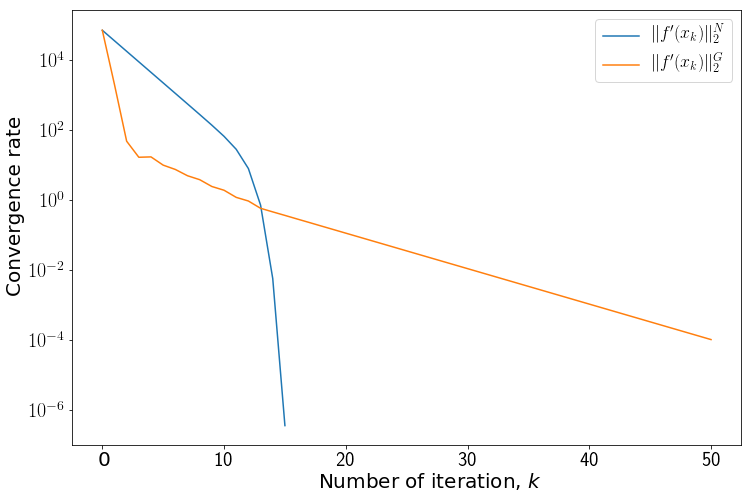

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.rc("text", usetex=True)
plt.xlabel(r"Number of iteration, $k$", fontsize=20)
plt.ylabel(r"Convergence rate", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=18)

#### Сравнение времени работы

In [7]:
%timeit newton.solve(x0, tol=1e-6, max_iter=50)
%timeit gd.solve(x0, tol=1e-6, max_iter=50)

18.4 s ± 831 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.34 s ± 60.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Метод Ньютона даёт очень точное решение за длительное время
- Метод градиентного спуска даёт не очень точное решение, но гораздо быстрее
- Часто бывает, что очень точное решение не требуется, поэтому градиентный спуск может быть предпочтительнее

## Pro & Contra

Pro

- квадратичная сходимость вблизи решения
- высокая точность полученного решения
- аффинная инвариантность
- параметры слабо влияют на скорость сходимости

Contra

- необходимо хранить гессиан на каждой итерации: $O(n^2)$ памяти
- необходимо решать линейные системы: $O(n^3)$ операций
- гессиан может оказаться вырожден
- гессиан может не быть положительно определён $\to$ направление $-(f''(x))^{-1}f'(x)$ может не быть направлением убывания

## Сравнение с градиентным методом (Б.Т. Поляк Введение в оптимизацию, гл. 3, $\S$ 1 )

Метод | Скорость сходимости | Сложность | Аффинная инвариантность | Требования к $f(x)$
:---: | :---: | :---: | :---: | :---
Градиентный спуск | Глобально линейная | $O(n) + $ определение шага | Нет | Дифференцируема; градиент липшицев
Метод Ньютона | Локально квадратичная | $O(n^3) + $ определение шага | Да | Дважды диференцируема; гессиан липшицев, положительно определён


## Что дальше?

- **Сложность:** как избавиться от решения систем линейных уравнений и хранения гессиана?
- **Сходимость:** как совместить локально квадратичную и глобально линейную скорости? Желательно получить глобально квадратичную сходимость!
- Требования к $f(x)$ необходимо минимизировать

## Как уменьшить сложность?

- Как не решать системы линейных уравнений говорят так называемые *квазиньютоновские методы* или *методы переменной метрики* - подробнее далее... 
- Как не хранить гессиан говорят методы типа [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) (Limited Broyden-Fletcher-Goldfarb-Shanno). Описание этих методов выходит за рамки курса, однако они являются наиболее употребимыми методами решения задач безусловной оптимизации больших размерностей.

## Как решить проблему локальной сходимости?

Этот вопрос будет затронут на семинаре про использование 

метода наименьших квадратов...

## Квазиньютоновские методы

Ещё раз сравним градиентный метод и метод Ньютона:
- градиентный метод получен из аппроксимации первого порядка:
$$
f_g(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2\alpha}\|x - y\|_2^2
$$
причём при $\alpha \in (0, 1/L], f(x) \leq f_g(x)$, то есть $f_g$ - глобальная оценка $f(x)$
- метод Ньютона получен из аппроксимации второго порядка
$$
f_N(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}f''(y)(x-y)
$$

**Идея:** использовать промежуточную аппроксимацию вида

$$
f_q(x) \approx f(y) + \langle f'(y), x - y \rangle + \frac{1}{2} (x-y)^{\top}{\color{red}{B(y)}}(x-y),
$$

которая даёт переход к следующей точке (полная аналогия с методом Ньютона):

$$
x_{k+1} = x_k - \alpha B^{-1}_k f'(x_k) = x_k - \alpha H_k f'(x_k)
$$

### Немного истории...
- Первый квазиньютоновский метод придумал физик William Davidon в середине 1950-х для ускорения своих вычислений на ненадёжных компьютерах
- Его статью с описанием предложенного метода не приняли к публикации, и она оставалась техническим отчётом <br></br> более 30 лет
- [Опубликована](http://epubs.siam.org/doi/abs/10.1137/0801001) в 1991 году в первом выпуске [SIAM Journal on Optimization](https://www.siam.org/journals/siopt.php) 

### Общая схема квазиньютоновских методов

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

### Как искать $B_{k+1}$?

В точке $x_{k+1}$ имеем следующую аппрокисмацию:

$$
f_q(h) \approx f(x_{k+1}) + \langle f'(x_{k+1}), h \rangle + \frac{1}{2}h^{\top}B_{k+1}h
$$

Из определения, очевидно, что $B_{k+1} \in \mathbb{S}^n_{++}$.
Какие требования естественно наложить на $f_q(h)$?

$$
f_q'(-\alpha_k h_k) = f'(x_k) \qquad f'_q(0) = f'(x_{k+1}),
$$

где первое условие даёт

$$
f'(x_{k+1}) - \alpha_k B_{k+1}h_k = f'(x_k),
$$

а второе выполняется автоматически.

### Квазиньютоновское уравнение (Secant equation)

Из первого условия получаем

$$
B_{k+1}s_k = y_k,
$$

где $s_k = x_{k+1} - x_k$ и $y_k = f'(x_{k+1}) - f'(x_k)$.

Это уравнение будет иметь решение только при $s^{\top}_k y_k > 0$. Почему?

**Вопрос:** всегда ли выполнено такое соотношение 

между разностью градиентов и точек?

**Вопрос:** единственным ли образом определено $B_{k+1}$?

### Как однозначно определить $B_{k+1}$?

\begin{equation}
\begin{split}
& \min_B \| B_k - B \| \\
\text{s.t. } & B = B^{\top}\\
& Bs_k = y_k
\end{split}
\end{equation}

### DFP (Davidon-Fletcher-Powell)
$$
B_{k+1} = (I - \rho_k y_k s^{\top}_k)B_k(I - \rho_k s_ky^{\top}_k) + \rho_k y_k y^{\top}_k,
$$
где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$,

или с помощью формулы Шермана-Морисона-Вудбери

$$
B^{-1}_{k+1} = H_{k+1} = H_k - \dfrac{H_ky_k y_k^{\top}H_k}{y^{\top}_kH_ky_k} + \dfrac{s_ks^{\top}_k}{y^{\top}_ks_k}
$$

**Вопрос:** какой ранг у матрицы преобразования $B_{k+1}$ и $H_{k+1}$?

### BFGS

<center><img src="./bfgs.png" width="600" /img></center>
**Вопрос:** какая естественная модификация метода DFP?

\begin{equation}
\begin{split}
& \min_H \| H_k - H \| \\
\text{s.t. } & H = H^{\top}\\
& Hy_k = s_k
\end{split}
\end{equation}

Формула пересчёта для метода BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

где $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

## Pro & Contra

Pro:
1. Вместо **точного** вычисления гессиана используется его **оценка**, полученная с помощью градиента и оценки гессиана в предыдущей точке
2. Вместо решения систем линейных уравнений используется текущаю информация о функции и градиенте для аналитического вычисления приближения обращённого гессиана
3. Сложность одной итерации $O(n^2) + ...$ по сравнению с $O(n^3) + ...$ в методе Ньютона
4. Свойство самокоррекции: если на некоторой итерации обратный гессиан оценен очень грубо, то следующие несколько итераций улучшат оценку
5. Сверхлинейная сходимость к решению задачи минимизации $f$ (подробнее см. [[1]](http://www.bioinfo.org.cn/~wangchao/maa/Numerical_Optimization.pdf))

Contra:
1. Нет универсального рецепта выбора начального приближения $B_0$ или $H_0$
2. Нет разработанной теории сходимости и оптимальности
3. Не любое условие на линейный поиск шага гарантирует выполнения условия кривизны $y^{\top}_ks_k > 0$

## Barzilai-Borwein method

- Первая [статья](http://pages.cs.wisc.edu/~swright/726/handouts/barzilai-borwein.pdf) об этом методе опубликована в 1988, в журнале IMA Journal of Numerical Analysis
- [Статья](http://papers.nips.cc/paper/6286-barzilai-borwein-step-size-for-stochastic-gradient-descent.pdf) на NIPS 2016 о модификации этого метода в случае использования стохастической оценки градиента
- Идея: комбинация идеи наискорейшего спуска и квазиньютоновского метода

## Идея метода

- Наискорейший спуск: $x_{k+1} = x_k - \alpha_k f'(x_k)$, $\alpha_k = \arg \min\limits_{\alpha > 0} f(x_{k+1})$
- Метод Ньютона: $x_{k+1} = x_k - (f''(x_k))^{-1} f'(x_k)$
- Аппроксимация гессиана диагональной матрицей:

$$
\alpha_k f'(x_k) = \alpha_k I f'(x_k) = \left( \frac{1}{\alpha_k} I \right)^{-1} f'(x_k) \approx f''(x_k))^{-1} f'(x_k)
$$

- Как найти $\alpha_k$?

### Снова квазиньютоновское уравнение (Secant equation)
- Для точного гессиана
$$
f''(x_{k})(x_{k} - x_{k-1}) = f'(x_{k}) - f'(x_{k-1})
$$
- Для приближения

$$
\alpha_k^{-1} s_{k-1} \approx y_{k-1}
$$

- Задача аппроксимации одного вектора с помощью масштабирования другого
- Простейший квазиньютоновский метод вырождается в поиск оптимального шага

## Три способа найти $\alpha_k$

- Первый способ
    - Задача
    
    $$
    \min_{\beta} \|\beta s_{k-1} - y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{1}{\beta} = \frac{s^{\top}_{k-1} s_{k-1}}{s^{\top}_{k-1} y_{k-1}}
    $$
    
- Второй способ
    - Задача
    
    $$
    \min_{\alpha} \| s_{k-1} - \alpha y_{k-1} \|^2_2
    $$
    
    - Решение
    
    $$
    \alpha = \frac{s^{\top}_{k-1} y_{k-1}}{y^{\top}_{k-1} y_{k-1}}
    $$
- Третий способ называется немонотонный линейный поиск: специальная модификация правил Армихо, учитывающая историю изменений значения функции, [статья](https://www.math.lsu.edu/~hozhang/papers/nonmonotone.pdf) 2004 г. в SIAM Journal on Optimization

## Эксперименты

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [6]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [7]:
bb = methods.BB_method(f, grad_f, init_alpha=1e-4, type=1)    
x_bb = bb.solve(x0, tol=1e-5, max_iter=100)

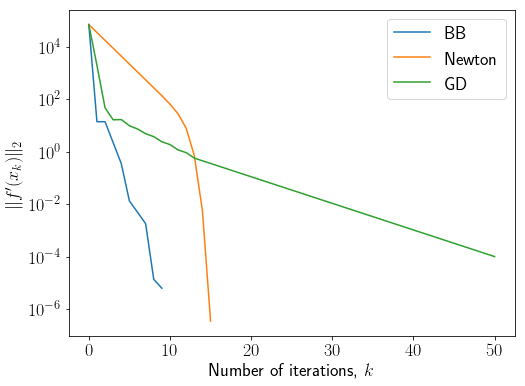

In [8]:
plt.figure(figsize=(8, 6))
plt.semilogy([np.linalg.norm(grad_f(x)) for x in bb.get_convergence()], label="BB")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="Newton")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="GD")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [10]:
%timeit bb.solve(x0, tol=1e-5, max_iter=100)

91.2 ms ± 9.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Плохо обусловленная задача 

In [9]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 49.999999999997954


In [10]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [11]:
gd = methods.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b))
x_grad = gd.solve(x0, tol=1e-6, max_iter=100)

bb_1 = methods.BB_method(f, gradf, init_alpha=1e-4, type=1)    
x_bb_1 = bb_1.solve(x0, tol=1e-6, max_iter=100)

bb_2 = methods.BB_method(f, gradf, init_alpha=1e-4, type=2)
x_bb = bb_2.solve(x0, tol=1e-6, max_iter=100)

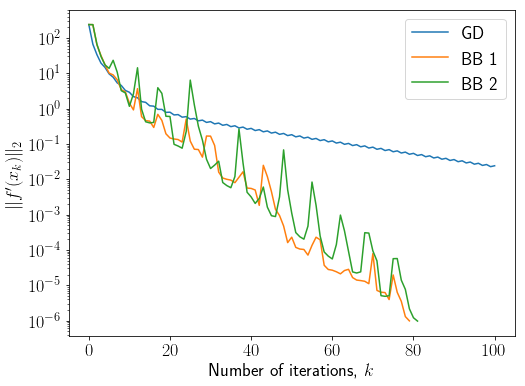

In [12]:
plt.figure(figsize=(8, 6))
plt.semilogy([np.linalg.norm(gradf(x)) for x in gd.get_convergence()], label='GD')
plt.semilogy([np.linalg.norm(gradf(x)) for x in bb_1.get_convergence()], label='BB 1')
plt.semilogy([np.linalg.norm(gradf(x)) for x in bb_2.get_convergence()], label='BB 2')
plt.legend(fontsize=18)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

## Резюме

1. Метод Ньютона
2. Теоремы сходимости
4. Сравнение с градиентным спуском
5. Эксперименты
6. Квазиньютоновские методы